![alt text](marta_Logo_of_the_Metropolitan_Atlanta_Rapid_Transit_Authority.png "MARTA Logo")

<h1 align=center><font size = 5>Segmenting and Clustering MARTA Rail Stations in Atlanta</font></h1>

## Abstract

In this notebook, I explore and visualize data for venues around MARTA rail stations in Atlanta. First, I use Foursquare to get  popular venues near each station. Next, I use Foursquare categories hierarchy to assign each venue to a general category, thus significantly reducing data dimensionality. Then I explore primary and general venue categories for each station, and use TF-IDF normalization and LDA algorithm to generate  station labels. I also use K-means, DBSCAN and hierarchical clustering algorithms to group stations into category-related clusters. Finally, I visualize all my results in interactive Folium maps.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px" >

<font size = 3>

<b>[Introduction/Business Problem](#item000)</b>
<p>
<b>[1. MARTA Stations Data](#item100)</b> 
<p>
    [1.1 Wikipedia Data](#item110)    
                                        
    [1.2 Foursquare Venue Data](#item120)      

    [1.3 Foursquare Categories Hierarchy](#item130)  
    
    [1.4 Entries/Day vs Number of Venues](#item140)                                                                                
<p>
<b>[2. MARTA Stations Labels](#item200)</b>   
<p>
    [2.1 Venues with Most Traffic](#item210)   
                                      
    [2.2 Venues Specific for Each Station: TF-IDF](#item220)       
    
    [2.3 Venues Specific for Each Station: TF-IDF LDA](#item230)   
    
    [2.4 MARTA Word Cloud](#item240)                                       
<p>
<b>[3. MARTA Stations Clusters](#item300)</b>   
<p>
    [3.1 K-means](#item310)    

    [3.2 DBSCAN](#item320)  
    
    [3.3 Hierarchical Clustering](#item330)     
    
    [3.4 Agglomerative Hierarchical Clustering](#item340)       
<p>
<b>[4. MARTA Stations Annotated Maps](#item400)</b>    
<p>            
<b>[Results](#item500)</b>   
<p>            
<b>[Discussion](#item600)</b>   
<p>            
<b>[Conclusion](#item700)</b>  
</font>
</div>

# Introduction/Business Problem  <a class="anchor" id="item000"></a>


We are going to explore venues associated with each of 38 MARTA rail stations in Atlanta, Georgia.  

This might help us answer the following questions.

Why people use MARTA?  
What attracts them to each MARTA station and makes them go there?  
Where do they go before\after riding MARTA?   
Where do they spend the most time (and money)?  
Are MARTA stations similar or dissimilar in respect to the venues near them?  
Can we label each MARTA station with venue categories that are specific for this station?  

In our analysis, we will use Foursquare API to get the most popular venues near each MARTA station, TF-IDF normalization and LDA algorithm for labeling each station, k-means and hierarchical clustering for grouping similar stations, and Folium library to visualize our results.

MARTA station names and their coordinates can be extracted from Wikipedia https://en.wikipedia.org/wiki/MARTA_rail

# 1. MARTA Stations Data  <a class="anchor" id="item100"></a>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1.1 Wikipedia Data <a class="anchor" id="item110"></a>   

Atlanta MARTA rail network has a total of 38 stations. In order to segement the stations and explore them, we will essentially need a dataset that contains the list of MARTA stations with the latitude and logitude coordinates of each station. 

Luckily, this data exists for free on Wikipedia: https://en.wikipedia.org/wiki/MARTA_rail
It can be easily downloaded and converted to Excel file.

In [2]:
bFoursquare = False # False: read local csv file instead of foursquare.com

In [3]:
stations = pd.read_excel('MARTA_stations.xlsx')
print(stations.shape)
stations.head()

(38, 5)


,Station,Entries/Day,Latitude,Longitude,Parking
0,Airport,9173,33.640758,-84.446341,0
1,Arts Center,6605,33.789705,-84.387789,0
2,Ashby,1791,33.756346,-84.417556,1
3,Avondale,4327,33.775277,-84.281903,1
4,Bankhead,1903,33.771890,-84.428840,0


Now we can create a map of Atlanta with MARTA stations superimposed on top.

We will use geopy library to get the latitude and longitude values of Downtown Atlanta. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>atlanta_explorer</em>, as shown below.

In [4]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="atlanta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Atlanta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Atlanta are 33.7490987, -84.3901849.


Let's visualize MARTA stations setting marker radius proportional to "Entries/Day".

In [5]:
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label, num  in zip(stations['Latitude'], stations['Longitude'], stations['Station'], stations['Entries/Day']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=num / 500,
        popup=label,
        color='red',
        fill=True,
        fill_color='#f4a8a7', #'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  

map_downtown.save('MARTA_map_Entries.html')
map_downtown

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the station.

## 1.2 Foursquare Venue Data <a class="anchor" id="item120"></a>   

Next, we are going to start utilizing the Foursquare API to explore the stations and segment them.

#### Define Foursquare Credentials and Version

CLIENT_ID = '???????????' # your Foursquare ID  
CLIENT_SECRET = '??????????????' # your Foursquare Secret  
VERSION = '20180605' # Foursquare API version  

In [6]:
# @hidden_cell



#### Let's explore the first station in our dataframe

Get the neighborhood's name.

In [7]:
ista = 33
stations.loc[ista, 'Station']

'Peachtree Center'

Get the neighborhood's latitude and longitude values.

In [8]:
station_latitude = stations.loc[ista, 'Latitude']
station_longitude = stations.loc[ista, 'Longitude'] 
station_name = stations.loc[ista, 'Station'] 
print('Latitude and longitude values of {} are {}, {}.'.format(station_name, 
                                                               station_latitude, 
                                                               station_longitude))

Latitude and longitude values of Peachtree Center are 33.759677, -84.387548.


Now, let's get the top 100 venues within a radius of 500 meters from this station

First, let's create the GET request URL. 

In [9]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    station_latitude, 
    station_longitude, 
    radius, 
    LIMIT)

Send the GET request and convert json data into a *pandas* dataframe. All the information is in the *items* key. 

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
if bFoursquare:
    # query
    results = requests.get(url).json()

    # JSON
    venues = results['response']['groups'][0]['items']

    # flatten JSON
    nearby_venues = json_normalize(venues) 

    # filter columns
    filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
    nearby_venues.head()

It seems Foursquare's API has a 100 result limit. We can get more results by using a nearby point. The results may overlap, so we will need to filter the duplicates out and keep changing the point by a tiny margin till the number of unique results stops growing or reaches specified LIMIT. We will leave it beyond the scope of this project for right now, and proceed with results limited to 100.

Let's create a function to repeat the same process to all MARTA stations 

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue ID', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we run the above function on each neighborhood and create a new dataframe called *venues_primary*.

Let's save venues_primary to a backup csv file so that we could re-use it later 

In [13]:
if bFoursquare:
    venues_primary = getNearbyVenues(names=stations['Station'],
                                   latitudes=stations['Latitude'],
                                   longitudes=stations['Longitude']
                                  )
    venues_primary.to_csv("MARTA_venues.csv",index=False) 
    print(venues_primary.shape)
    print(venues_primary.groupby('Station').count()) #venues were returned for each station
    venues_primary.head()

Let's read venues_primary from csv file

In [14]:
venues_primary = pd.read_csv("MARTA_venues.csv")
stations = pd.read_excel('MARTA_stations.xlsx')
print(venues_primary.shape)
venues_primary.head()

(1156, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Airport,33.640758,-84.446341,Starbucks,33.640891,-84.444769,Coffee Shop
1,Airport,33.640758,-84.446341,Metal Penguin,33.640059,-84.444530,Public Art
2,Airport,33.640758,-84.446341,Zimbabwe: A Tradition in Stone,33.640745,-84.442539,Art Gallery
3,Airport,33.640758,-84.446341,TSA PreCheck North,33.641276,-84.444029,Airport Service
4,Airport,33.640758,-84.446341,Starbucks,33.641678,-84.446620,Coffee Shop


In [15]:
venues_count = venues_primary[['Station','Venue']].groupby('Station').count().reset_index().set_index('Station')

Let's visualize MARTA stations setting marker radius proportional to "Venues".

In [16]:
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label, num, cnt  in zip(stations['Latitude'], stations['Longitude'], stations['Station'], stations['Entries/Day'], venues_count['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=cnt / 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  

map_downtown.save('MARTA_map_Venues.html')
map_downtown

Now we have all data ready for our analysis,

## 1.3 Foursquare Categories Hierarchy <a class="anchor" id="item130"></a>    

Let's find out how many unique venues we have found. Some stations are located close to each other and can share some venues. This is OK for the purposes of our analysis, but let's check it.

In [17]:
tmp = venues_primary.groupby(['Venue Latitude','Venue Longitude']).size().reset_index().rename(columns={0:'count'})
print('There are {} uniques venues out of total {}.'.format(tmp.shape[0],venues_primary.shape[0]))

There are 1101 uniques venues out of total 1156.


Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(venues_primary['Venue Category'].unique())))

There are 223 uniques categories.


Let's encode our categories using One Hot method

In [19]:
def one_hot_encoding(venues):
    # one hot encoding
    onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot['Station'] = venues['Station'] 

    # move Station column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    
    return onehot

In [20]:
primary_onehot = one_hot_encoding(venues_primary)
print(primary_onehot.shape)
primary_onehot.head()

(1156, 224)


,Station,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Beer Store,Betting Shop,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Taxi,Taxi Stand,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Lounge,Tunnel,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Notice that each row has exactly one non-zero value. Let's now group them by Station.

In [21]:
primary = primary_onehot.groupby('Station').sum().reset_index()
primary

,Station,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Beer Store,Betting Shop,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Taxi,Taxi Stand,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Lounge,Tunnel,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Airport,0,2,4,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arts Center,0,0,0,0,2,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,6,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2

#### Extract General Categories 

Our data with 223 primary categories is very sparse. Let's get some more general categories so that we could merge, e.g. Airport Service and Airport Lounge into one general category Airport. We can use Foursquare categories hierarchy tree for this.

In [22]:
categories_list = primary.columns.tolist()
for x in range(len( categories_list)): 
    print(categories_list[x])

Station
Accessories Store
Airport Lounge
Airport Service
Airport Terminal
American Restaurant
Aquarium
Art Gallery
Art Museum
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Automotive Shop
BBQ Joint
Bagel Shop
Bakery
Bank
Bar
Basketball Stadium
Bath House
Beer Store
Betting Shop
Big Box Store
Bistro
Bookstore
Boutique
Breakfast Spot
Brewery
Bubble Tea Shop
Burger Joint
Burrito Place
Bus Line
Bus Station
Business Service
Cafeteria
Café
Cajun / Creole Restaurant
Candy Store
Caribbean Restaurant
Cemetery
Chinese Restaurant
Chiropractor
Chocolate Shop
Clothing Store
Cocktail Bar
Coffee Shop
College Basketball Court
Comedy Club
Concert Hall
Construction & Landscaping
Convenience Store
Convention Center
Cosmetics Shop
Cuban Restaurant
Cupcake Shop
Cycle Studio
Deli / Bodega
Department Store
Dessert Shop
Diner
Disc Golf
Discount Store
Dive Bar
Doctor's Office
Dog Run
Donut Shop
Eastern European Restaurant
Electronics Store
Ethiopian Restaurant
Event Space
Exhibit
Eye Doctor
Falafel R

Get Foursquare categories hierarchy tree. 

In [23]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

In [24]:
categories_tree = requests.get(url).json()
categories_tree['response']

{'categories': [{'categories': [{'categories': [],
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
      'suffix': '.png'},
     'id': '56aa371be4b08b9a8d5734db',
     'name': 'Amphitheater',
     'pluralName': 'Amphitheaters',
     'shortName': 'Amphitheater'},
    {'categories': [],
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
      'suffix': '.png'},
     'id': '4fceea171983d5d06c3e9823',
     'name': 'Aquarium',
     'pluralName': 'Aquariums',
     'shortName': 'Aquarium'},
    {'categories': [],
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/arcade_',
      'suffix': '.png'},
     'id': '4bf58dd8d48988d1e1931735',
     'name': 'Arcade',
     'pluralName': 'Arcades',
     'shortName': 'Arcade'},
    {'categories': [],
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/artgallery_',
      'suffix': '.png'},
     'id': '4b

We need a function to get tree path given a category name. It will return a list with category name in the very last element, and its root category in the first (0th) element.

In [25]:
def get_category_path(json_tree, target_name, path):
    for node in json_tree:                    
        if type(node) == dict:
            node_name = node.get("name")
            #print("path=", path + [node_name])  
            
            for key,value in node.items():
                if key == "name":
                    #print(key," = ",value)
                    if value == target_name:
                        #print("FOUND ", key," = ",value)
                        return path + [target_name]
                elif key == "categories":
                    check_child = get_category_path(value, target_name, path + [node_name])
                    if check_child:
                        return check_child

print(get_category_path(categories_tree['response']['categories'], 'Aquarium', []))
print(get_category_path(categories_tree['response']['categories'], 'Art Museum', []))
print(get_category_path(categories_tree['response']['categories'], 'Asian Restaurant', []))
print(get_category_path(categories_tree['response']['categories'], 'Japanese Restaurant', []))
print(get_category_path(categories_tree['response']['categories'], 'Nightclub', []))
print(get_category_path(categories_tree['response']['categories'], 'Whisky Bar', []))
print(get_category_path(categories_tree['response']['categories'], 'Women\'s Store', []))
print(get_category_path(categories_tree['response']['categories'], 'Pharmacy', []))
print(get_category_path(categories_tree['response']['categories'], 'Gas Station', []))
print(get_category_path(categories_tree['response']['categories'], 'Park', []))
print(get_category_path(categories_tree['response']['categories'], 'Yoga Studio', []))
print(get_category_path(categories_tree['response']['categories'], 'Chiropractor', []))
print(get_category_path(categories_tree['response']['categories'], 'Event Space', []))
print(get_category_path(categories_tree['response']['categories'], 'College Basketball Court', []))
print(get_category_path(categories_tree['response']['categories'], 'Residential Building (Apartment / Condo)', []))
print(get_category_path(categories_tree['response']['categories'], 'Airport Lounge', []))
print(get_category_path(categories_tree['response']['categories'], 'Light Rail Station', []))

['Arts & Entertainment', 'Aquarium']
['Arts & Entertainment', 'Museum', 'Art Museum']
['Food', 'Asian Restaurant']
['Food', 'Asian Restaurant', 'Japanese Restaurant']
['Nightlife Spot', 'Nightclub']
['Nightlife Spot', 'Bar', 'Whisky Bar']
['Shop & Service', 'Clothing Store', "Women's Store"]
['Shop & Service', 'Pharmacy']
['Shop & Service', 'Gas Station']
['Outdoors & Recreation', 'Park']
['Outdoors & Recreation', 'Athletics & Sports', 'Gym / Fitness Center', 'Yoga Studio']
['Professional & Other Places', 'Medical Center', 'Chiropractor']
['Professional & Other Places', 'Event Space']
['College & University', 'College Stadium', 'College Basketball Court']
['Residence', 'Residential Building (Apartment / Condo)']
['Travel & Transport', 'Airport', 'Airport Lounge']
['Travel & Transport', 'Light Rail Station']


Now we are ready to extract general category for each primary category

In [26]:
categories_dict = {}
general_list = categories_list.copy()
for x in range(len(categories_list)): 
    a = get_category_path(categories_tree['response']['categories'], categories_list[x], [])
    if a:
        if len(a) >= 2:
            a = a[0]; # immediate parent: a[-2];
        else:
            a = a[0]; # return itself
        print(a)
        categories_dict[categories_list[x]] = a
    else:
        a = ""
    print(categories_list[x], " --> ", a)
    general_list[x] = a

Station  -->  
Shop & Service
Accessories Store  -->  Shop & Service
Travel & Transport
Airport Lounge  -->  Travel & Transport
Travel & Transport
Airport Service  -->  Travel & Transport
Travel & Transport
Airport Terminal  -->  Travel & Transport
Food
American Restaurant  -->  Food
Arts & Entertainment
Aquarium  -->  Arts & Entertainment
Arts & Entertainment
Art Gallery  -->  Arts & Entertainment
Arts & Entertainment
Art Museum  -->  Arts & Entertainment
Shop & Service
Arts & Crafts Store  -->  Shop & Service
Food
Asian Restaurant  -->  Food
Outdoors & Recreation
Athletics & Sports  -->  Outdoors & Recreation
Shop & Service
Automotive Shop  -->  Shop & Service
Food
BBQ Joint  -->  Food
Food
Bagel Shop  -->  Food
Food
Bakery  -->  Food
Shop & Service
Bank  -->  Shop & Service
Nightlife Spot
Bar  -->  Nightlife Spot
Arts & Entertainment
Basketball Stadium  -->  Arts & Entertainment
Shop & Service
Bath House  -->  Shop & Service
Shop & Service
Beer Store  -->  Shop & Service
Shop & Serv

In [27]:
print(len(np.unique(categories_list)))
print(len(np.unique(general_list)))

224
10


Let's change category names in venues_primary["Venue Category"] using categories_dict.

Original categories before renaming/merging:

In [28]:
venues_primary.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Airport,33.640758,-84.446341,Starbucks,33.640891,-84.444769,Coffee Shop
1,Airport,33.640758,-84.446341,Metal Penguin,33.640059,-84.444530,Public Art
2,Airport,33.640758,-84.446341,Zimbabwe: A Tradition in Stone,33.640745,-84.442539,Art Gallery
3,Airport,33.640758,-84.446341,TSA PreCheck North,33.641276,-84.444029,Airport Service
4,Airport,33.640758,-84.446341,Starbucks,33.641678,-84.446620,Coffee Shop


Categories after renaming into 9 general categories:

In [29]:
venues_general = pd.read_csv("MARTA_venues.csv")
venues_general['Venue Category'] = venues_general['Venue Category'].replace(categories_dict)
venues_general.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Airport,33.640758,-84.446341,Starbucks,33.640891,-84.444769,Food
1,Airport,33.640758,-84.446341,Metal Penguin,33.640059,-84.444530,Arts & Entertainment
2,Airport,33.640758,-84.446341,Zimbabwe: A Tradition in Stone,33.640745,-84.442539,Arts & Entertainment
3,Airport,33.640758,-84.446341,TSA PreCheck North,33.641276,-84.444029,Travel & Transport
4,Airport,33.640758,-84.446341,Starbucks,33.641678,-84.446620,Food


Let's apply One Hot encoding to this data

In [30]:
general_onehot = one_hot_encoding(venues_general)
print(general_onehot.shape)
general_onehot.head()

(1156, 10)


,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Airport,0,0,1,0,0,0,0,0,0
1,Airport,1,0,0,0,0,0,0,0,0
2,Airport,1,0,0,0,0,0,0,0,0
3,Airport,0,0,0,0,0,0,0,0,1
4,Airport,0,0,1,0,0,0,0,0,0


In [31]:
general = general_onehot.groupby('Station').sum().reset_index()
general

,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Airport,2,0,12,0,0,0,0,3,10
1,Arts Center,13,0,21,4,2,0,0,5,3
2,Ashby,1,0,10,1,2,0,0,2,2
3,Avondale,1,0,3,2,6,1,0,7,1
4,Bankhead,0,0,1,0,1,0,0,1,0
5,Brookhaven/Oglethorpe,0,0,7,2,0,0,0,10,0
6,Buckhead,0,0,34,4,5,2,0,48,7
7,Chamblee,0,0,7,0,1,0,0,9,0
8,Civic Center,1,0,15,4,5,0,1,1,6
9,College Park,1,0,7,0,0,0,0,2,2


Compared to the table with 223 primary categories, this table with only 9 columns is much easier to interprete. 

In [32]:
general.sum()

Station                        AirportArts CenterAshbyAvondaleBankheadBrookha...
Arts & Entertainment                                                          69
College & University                                                           1
Food                                                                         537
Nightlife Spot                                                                72
Outdoors & Recreation                                                         82
Professional & Other Places                                                   13
Residence                                                                      3
Shop & Service                                                               279
Travel & Transport                                                           100
dtype: object

In [33]:
general.describe()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,1.815789,0.026316,14.131579,1.894737,2.157895,0.342105,0.078947,7.342105,2.631579
std,2.729768,0.162221,14.159652,2.807225,2.296017,0.582461,0.273276,10.027735,3.017257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000,0.000000,0.250000,0.000000,0.000000,2.000000,1.000000
50%,1.000000,0.000000,10.500000,0.500000,1.000000,0.000000,0.000000,4.000000,2.000000
75%,2.000000,0.000000,20.250000,3.750000,3.750000,1.000000,0.000000,8.000000,3.000000
max,13.000000,1.000000,60.000000,14.000000,9.000000,2.000000,1.000000,48.000000,14.000000


In [34]:
general[general['College & University'] > 0]

,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
19,Georgia State,2,1,22,0,2,1,0,4,1


In [35]:
general[general['Residence'] > 0]

,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
8,Civic Center,1,0,15,4,5,0,1,1,6
22,Inman Park/Reynoldstown,1,0,12,0,2,1,1,21,2
27,Lindbergh Center,0,0,18,6,3,0,1,18,0


In [36]:
general[general['Professional & Other Places'] > 0]

,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
3,Avondale,1,0,3,2,6,1,0,7,1
6,Buckhead,0,0,34,4,5,2,0,48,7
10,Decatur,1,0,38,3,4,1,0,13,1
11,Dome/GWCC/Philips Arena/CNN Center,8,0,31,5,6,1,0,5,2
17,Five Points,4,0,22,3,0,1,0,2,1
19,Georgia State,2,1,22,0,2,1,0,4,1
22,Inman Park/Reynoldstown,1,0,12,0,2,1,1,21,2
23,Kensington,0,0,0,0,0,1,0,3,0
26,Lenox,0,0,12,3,1,1,0,4,4
29,Midtown,3,0,60,6,7,1,0,17,6


Surprisingly, there are not so many Professional & Other Places venues in Foursquare results. Interestingly, tiny Kensington is also in this list, together with Buckhead and Peachtree Center. This is because Kensington's Utley Chiropractic (Utley Chiropractic & Wellness Center, to be precise) happens to fall into Professional & Other Places category.

Anyhow, Food, Shop & Service and Travel & Transport categories dominate areas around all MARTA stations in Atlanta.

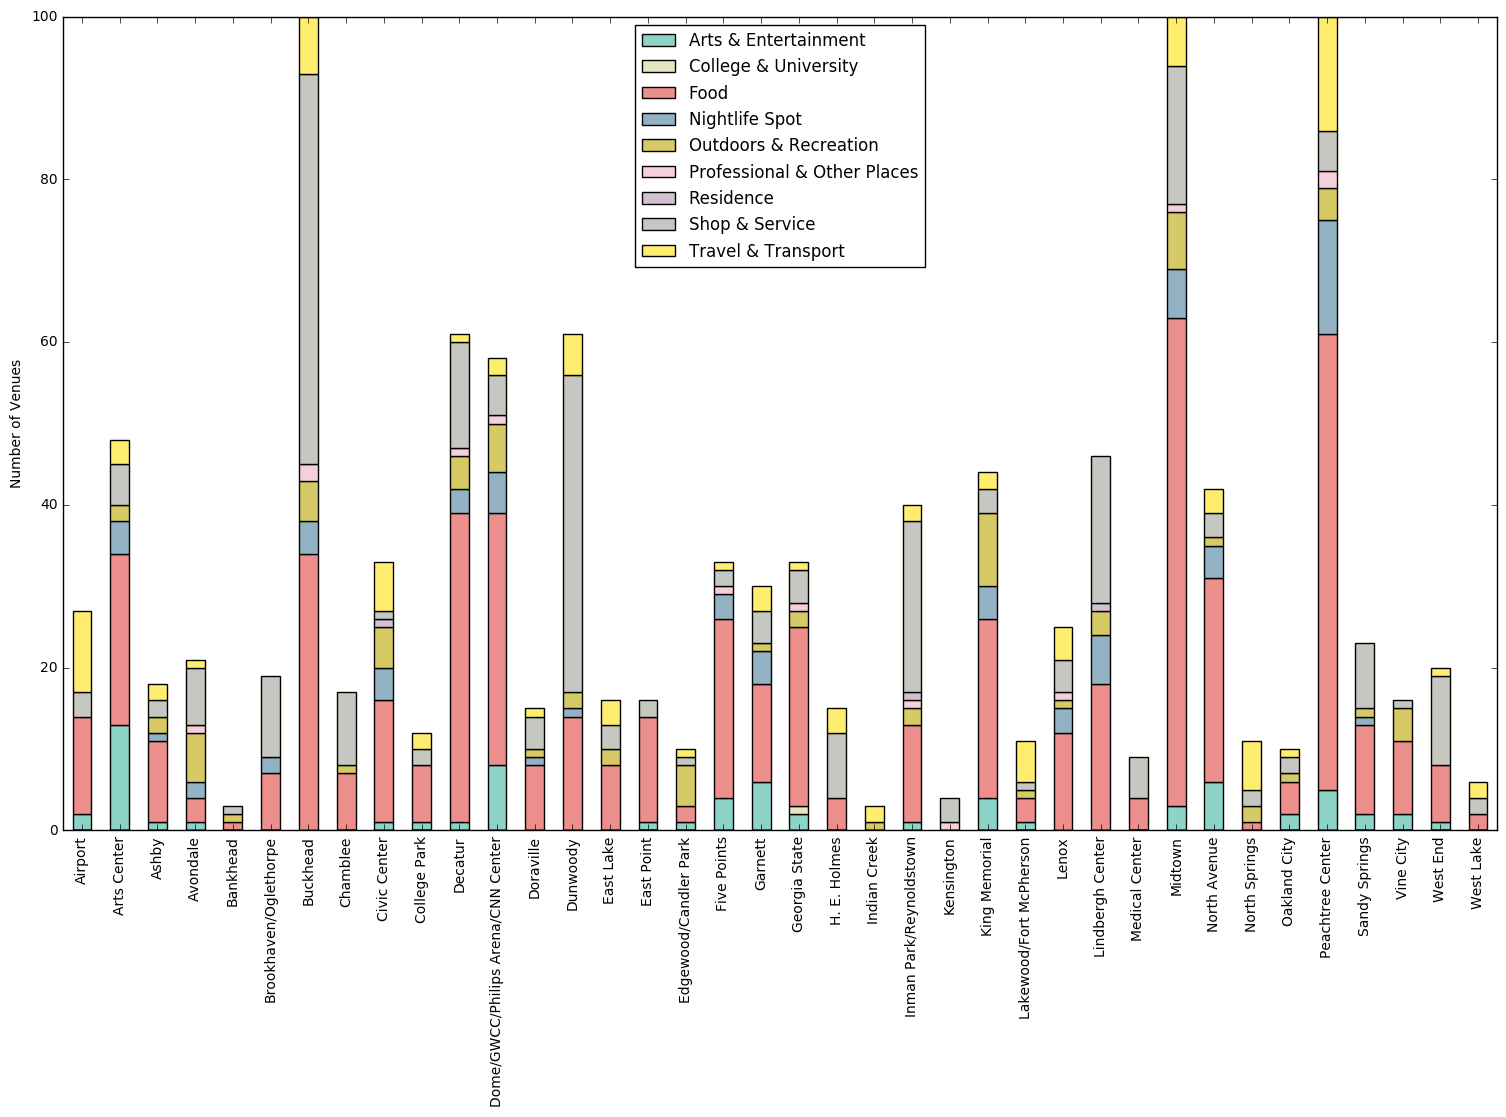

In [37]:
ax = general.plot(kind='bar', stacked=True, figsize=(18.5, 10.5), cmap="Set3") 
ax.set_ylabel('Number of Venues')
plt.xticks(np.arange(38), list(general['Station']))
plt.savefig('MARTA_stacked_general.png')
plt.show()

## 1.4 Entries/Day vs Number of Venues <a class="anchor" id="item140"></a>   

Now let's plot Entries/Day and number of venues for each station.

In [38]:
def split_it(name):
    return name.split('/')[0];
split_it("Inman Park/Reynoldstown")

'Inman Park'

In [39]:
# add number of venues to stations
merged = stations
merged = merged.join(venues_primary[['Station','Venue']].groupby('Station').count().reset_index().set_index('Station'), on='Station')
merged = merged.drop(['Latitude','Longitude'], axis=1)
#merged['Station'] = merged['Station'].apply(split_it) 
merged

,Station,Entries/Day,Parking,Venue
0,Airport,9173,0,27
1,Arts Center,6605,0,48
2,Ashby,1791,1,18
3,Avondale,4327,1,21
4,Bankhead,1903,0,3
5,Brookhaven/Oglethorpe,2357,2,19
6,Buckhead,2643,0,100
7,Chamblee,3785,1,17
8,Civic Center,2692,0,33
9,College Park,9026,2,12


In [40]:
def plot_scatter_entries_vs_venues(merged, ihighlights=[], name=""):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Number of Venues', fontsize = 10)
    ax.set_ylabel('Entries/Day', fontsize = 10)
    ax.set_title('MARTA Stations', fontsize = 15)
    ax.grid()
    
    targets = ['no parking', 'free daily', 'free daily & long-term']
    itargets = [0, 1, 2]
    markers = ['o', '^', 's']
    marker_colors = ['b', 'm', 'r']

    if len(ihighlights) == merged.shape[0]:
        # Interprete ihighlights as cluster labels 
        kclusters = np.unique(ihighlights).shape[0]
        xs = np.arange(kclusters)
        ys = [i + xs + (i*xs)**2 for i in range(kclusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]    
        
    for target, color, mark in zip(itargets,marker_colors,markers):
        indicesToKeep = (merged['Parking'] == target)
        ax.scatter(merged.loc[indicesToKeep, 'Venue']
                   , merged.loc[indicesToKeep, 'Entries/Day']
                   , c = color
                   , marker = mark
                   , s = 50)        
    ax.legend(targets)
    
    ix = merged.columns.get_loc("Venue")
    iy = merged.columns.get_loc("Entries/Day")
    for i in range(merged.shape[0]):
        if len(ihighlights) == merged.shape[0]:
            # Interprete ihighlights as cluster labels 
            #ax.scatter(merged.iloc[i,ix], merged.loc[i,iy], c = rainbow[ihighlights[i]-1], marker = 'o', s = 50)        
            ax.annotate(split_it(merged.iloc[i,0]), xy=(merged.iloc[i,ix]+1, merged.iloc[i,iy]), color=rainbow[ihighlights[i]-1])
        else:
            if i in ihighlights:
                ax.annotate(split_it(merged.iloc[i,0]), xy=(merged.iloc[i,ix]+1, merged.iloc[i,iy]), color="black")
            else:
                ax.annotate(split_it(merged.iloc[i,0]), xy=(merged.iloc[i,ix]+1, merged.iloc[i,iy]), color="grey")
    
    plt.xlim(0,120)
    plt.ylim(0,20000)

    # Separator of no-parking from free parking station
    plt.plot([26,26], [0,20000], color='red')
    
    # Save and show
    plt.savefig('MARTA_Entries_vs_Venues_'+name+'.png')
    plt.show()

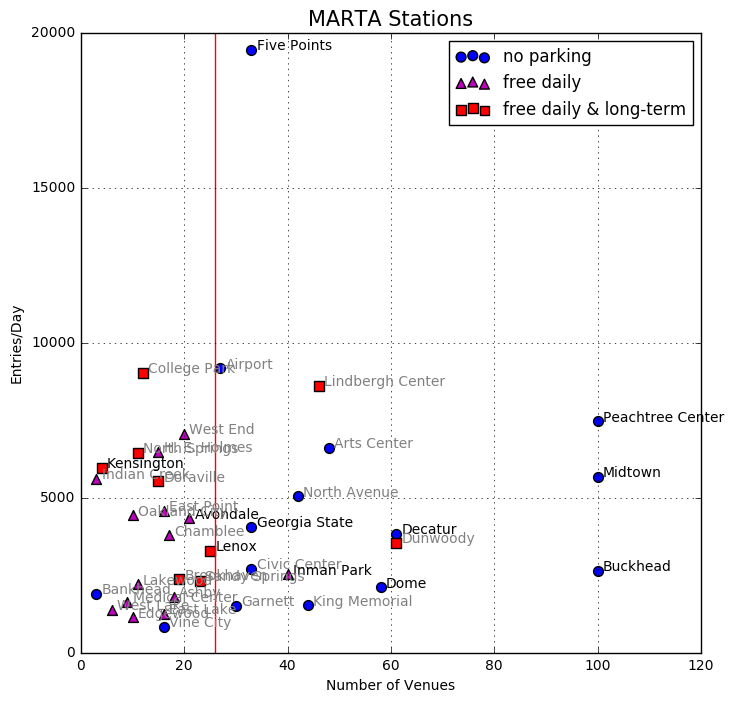

In [41]:
#plot_scatter_entries_vs_venues(merged, [], '')
plot_scatter_entries_vs_venues(merged, [3,6,10,11,17,19,22,23,26,29,33], 'Professional')

This plot shows 3 groups of stations: no parking (blue), with free daily parking (magenta) and with free daily & long-term parking (red). Stations with Professionl Services are shown in bold. 

Some observations:

- Number of venues is not correlated with Entries/Day, but is related to free parking. 

- A simple rule "Number of Venues <= 26" surprisingly well separates stations with parking from those with no parking. There are only 3 exceptions with parking (Dunwoody, Lindbergh Center, Inman Park) and 2 exceptions with no parking (Bankhead and Vine City). Lenox is near the boundary. It seems that MARTA stations with parking are mostly used by park-and-ride commuters. 

- Indian Creek, Kensington, College Park and North Springs have many Entries/Day, but a very small number of venues. Indian Creek has only 3 venues: Bus Station,Light Rail Station,Park. Kensington has 4 venues: Gas Station, Discount Store, Pharmacy, Chiropractor

- Five Points, which is a transit point between all four MARTA Rail lines, has the highest number of Entries per Day of all MARTA stations, but only 33 venues. 

- Buckhead, Midtown and Peachtree Center have average to high Entries/Day, and are surrounded with very many venues. There are also smaller stations like this, e.g. King Memorial, Dome, Dunwoody, Decatur, North Avenue, Arts Center, Lindbergh Center. All these stations seem to be located in dense areas with many different businesses.

- Bankhead and West Lake are very small both in number of venues and in Entries/Day. Bankhead has 3 venues: Gas Station, Park, Ice Cream Shop. West Lake has 6 venues: 2 Gas Stations, Light Rail Station, Bus Station, Wings Joint, Café

C:\Users\nely_\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\nely_\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


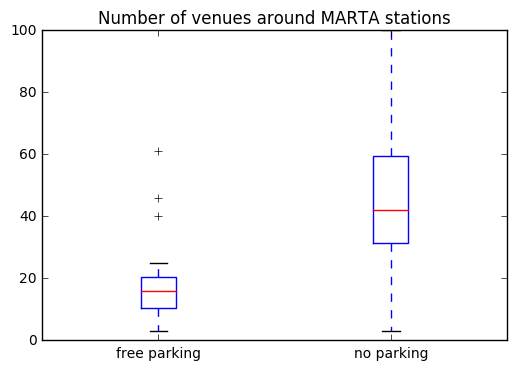

In [42]:
d0 = merged.loc[(merged['Parking'] == 0), 'Venue'].as_matrix()
d1 = merged.loc[(merged['Parking'] != 0), 'Venue'].as_matrix()
data_to_plot = [d1, d0]

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data_to_plot)
plt.title('Number of venues around MARTA stations')
ax.set_xticklabels(['free parking','no parking'])
plt.savefig('MARTA_Venues_boxplot.png')
plt.show()

# 2 MARTA Stations Labels <a class="anchor" id="item200"></a>   

## 2.1 Venues with Most Traffic <a class="anchor" id="item210"></a>   

Next, let's group venues by station and take the mean of the frequency of occurrence of each category

In [43]:
general = general_onehot.groupby('Station').mean().reset_index()
print(general.shape)
general.head()

(38, 10)


,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Airport,0.074074,0.0,0.444444,0.000000,0.000000,0.000000,0.0,0.111111,0.370370
1,Arts Center,0.270833,0.0,0.437500,0.083333,0.041667,0.000000,0.0,0.104167,0.062500
2,Ashby,0.055556,0.0,0.555556,0.055556,0.111111,0.000000,0.0,0.111111,0.111111
3,Avondale,0.047619,0.0,0.142857,0.095238,0.285714,0.047619,0.0,0.333333,0.047619
4,Bankhead,0.000000,0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.333333,0.000000


In [44]:
primary = primary_onehot.groupby('Station').mean().reset_index()
print(primary.shape)
primary.head()

(38, 224)


,Station,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Beer Store,Betting Shop,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Taxi,Taxi Stand,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Lounge,Tunnel,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Airport,0.0,0.074074,0.148148,0.037037,0.000000,0.0,0.037037,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.037037,0.000000,0.111111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.000000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.037037,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,

Let's print each station along with the top 5 most common venues

In [45]:
def print_top_categories(grouped=primary, num_top_venues=5):
    for hood in grouped['Station']:
        print("----"+hood+"----")
        temp = grouped[grouped['Station'] == hood].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp[temp.freq > 0] # print inly non-zero frequencies
        temp = temp.round({'freq': 2})
        num_top = np.min([num_top_venues,len(temp)])
        print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top))
        print('\n')

In [46]:
print_top_categories(grouped=general, num_top_venues=5)

----Airport----
                  venue  freq
0                  Food  0.44
1    Travel & Transport  0.37
2        Shop & Service  0.11
3  Arts & Entertainment  0.07


----Arts Center----
                  venue  freq
0                  Food  0.44
1  Arts & Entertainment  0.27
2        Shop & Service  0.10
3        Nightlife Spot  0.08
4    Travel & Transport  0.06


----Ashby----
                   venue  freq
0                   Food  0.56
1  Outdoors & Recreation  0.11
2         Shop & Service  0.11
3     Travel & Transport  0.11
4   Arts & Entertainment  0.06


----Avondale----
                   venue  freq
0         Shop & Service  0.33
1  Outdoors & Recreation  0.29
2                   Food  0.14
3         Nightlife Spot  0.10
4   Arts & Entertainment  0.05


----Bankhead----
                   venue  freq
0                   Food  0.33
1  Outdoors & Recreation  0.33
2         Shop & Service  0.33


----Brookhaven/Oglethorpe----
            venue  freq
0  Shop & Service  0.53
1 

In [47]:
print_top_categories(grouped=primary, num_top_venues=5)

----Airport----
             venue  freq
0  Airport Service  0.15
1      Coffee Shop  0.11
2   Airport Lounge  0.07
3      Art Gallery  0.04
4        BBQ Joint  0.04


----Arts Center----
                 venue  freq
0          Coffee Shop  0.12
1       Sandwich Place  0.08
2          Music Venue  0.06
3  American Restaurant  0.04
4          Pizza Place  0.04


----Ashby----
                  venue  freq
0           Wings Joint  0.17
1   American Restaurant  0.06
2        Cosmetics Shop  0.06
3  Fast Food Restaurant  0.06
4   Fried Chicken Joint  0.06


----Avondale----
                  venue  freq
0  Gym / Fitness Center  0.10
1                   Gym  0.10
2                Bakery  0.10
3          Liquor Store  0.10
4     Martial Arts Dojo  0.05


----Bankhead----
            venue  freq
0     Gas Station  0.33
1  Ice Cream Shop  0.33
2            Park  0.33


----Brookhaven/Oglethorpe----
         venue  freq
0     Pharmacy  0.11
1   Sports Bar  0.11
2  Pizza Place  0.05
3    Wine Sh

Let's write functions to sort the venues in descending order and display the top 10 venues for each station in a more compact tabular form.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    tmp = row_categories_sorted.index.values[0:num_top_venues]
    for i in range(num_top_venues):
        if row_categories_sorted[i] <= 0:
            tmp[i] = '-' 
    return tmp

In [49]:
def top_venues(grouped, num_top_venues, subset, bshorten_names=False):

    num_top = np.min([num_top_venues, grouped.shape[1]-1])
    
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Station']
    for ind in np.arange(num_top):
        try:
            columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Category'.format(ind+1))

    # create a new dataframe
    venues_sorted = pd.DataFrame(columns=columns)
    venues_sorted['Station'] = grouped['Station']
    
    # shorten station names if required
    if bshorten_names:
        venues_sorted['Station'] = venues_sorted['Station'].apply(split_it)

    # get sorted venues for each row
    if not subset:
        for ind in np.arange(grouped.shape[0]):
            venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top)
    else:
        for ind in np.arange(grouped.shape[0]):
            if ind in subset:
                venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top)
        venues_sorted = venues_sorted.loc[subset]
        
    return venues_sorted

In [50]:
general_top = top_venues(general, 10, [])
general_top.head()

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category
0,Airport,Food,Travel & Transport,Shop & Service,Arts & Entertainment,-,-,-,-,-
1,Arts Center,Food,Arts & Entertainment,Shop & Service,Nightlife Spot,Travel & Transport,Outdoors & Recreation,-,-,-
2,Ashby,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,-,-,-
3,Avondale,Shop & Service,Outdoors & Recreation,Food,Nightlife Spot,Travel & Transport,Professional & Other Places,Arts & Entertainment,-,-
4,Bankhead,Shop & Service,Outdoors & Recreation,Food,-,-,-,-,-,-


In [51]:
primary_top = top_venues(primary, 10, [])
primary_top.head()

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Airport,Airport Service,Coffee Shop,Airport Lounge,Rental Car Location,Bakery,Food Stand,Bus Station,Clothing Store,Fast Food Restaurant,Sandwich Place
1,Arts Center,Coffee Shop,Sandwich Place,Music Venue,Performing Arts Venue,Hotel,Pizza Place,American Restaurant,Theater,Comedy Club,Exhibit
2,Ashby,Wings Joint,Pool,Sandwich Place,Sports Bar,Music Venue,Southern / Soul Food Restaurant,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Light Rail Station
3,Avondale,Bakery,Gym / Fitness Center,Gym,Liquor Store,Cycle Studio,Cosmetics Shop,Coffee Shop,Clothing Store,Office,Spa
4,Bankhead,Ice Cream Shop,Gas Station,Park,-,-,-,-,-,-,-


This table shows most popular venues, with largest foot traffic.  We can see that these are mostly fast food eateries and coffee shops.

Let's have a closer look at some stations

In [52]:
top_venues(general, 10, [0,1,6,17,19,27])

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category
0,Airport,Food,Travel & Transport,Shop & Service,Arts & Entertainment,-,-,-,-,-
1,Arts Center,Food,Arts & Entertainment,Shop & Service,Nightlife Spot,Travel & Transport,Outdoors & Recreation,-,-,-
6,Buckhead,Shop & Service,Food,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,-,-,-
17,Five Points,Food,Arts & Entertainment,Nightlife Spot,Shop & Service,Travel & Transport,Professional & Other Places,-,-,-
19,Georgia State,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Professional & Other Places,College & University,-,-
27,Lindbergh Center,Shop & Service,Food,Nightlife Spot,Outdoors & Recreation,Residence,-,-,-,-


In [53]:
top_venues(primary, 10, [0,1,6,17,19,27])

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Airport,Airport Service,Coffee Shop,Airport Lounge,Rental Car Location,Bakery,Food Stand,Bus Station,Clothing Store,Fast Food Restaurant,Sandwich Place
1,Arts Center,Coffee Shop,Sandwich Place,Music Venue,Performing Arts Venue,Hotel,Pizza Place,American Restaurant,Theater,Comedy Club,Exhibit
6,Buckhead,Clothing Store,Cosmetics Shop,Hotel,Steakhouse,Furniture / Home Store,Women's Store,Department Store,American Restaurant,Bakery,Jewelry Store
17,Five Points,Sandwich Place,Pharmacy,Burger Joint,Event Space,Lounge,Falafel Restaurant,Coffee Shop,Bubble Tea Shop,Sports Bar,Theater
19,Georgia State,Sandwich Place,Coffee Shop,Breakfast Spot,Fast Food Restaurant,Asian Restaurant,Shoe Store,Bubble Tea Shop,Burger Joint,Mexican Restaurant,Movie Theater
27,Lindbergh Center,Coffee Shop,Sandwich Place,Shopping Plaza,Fast Food Restaurant,Gym,Nightclub,Shipping Store,Salon / Barbershop,Shopping Mall,Smoke Shop


## 2.2 Venues Specific for Each Stations: TF-IDF <a class="anchor" id="item220"></a>   

Let's now see what makes each MARTA station special and distinct from other stations.

We can do it by using Term Frequency-Inverse Document Frequency (TF-IDF) and similar techniques that are widely used in text processing for normalizing word counts in a corpus of N documents. In our case "word" is a category, and "document" is a station. Each station ("document") can be viewed as a bag of categories ("words") of all venues near that station. 

- Term Frequency (TF) = (Number of times a word w appears in a document d)/(Total number of words in the document d)

- Inverse Document Frequency (IDF) = -log(n/N), where, N is the total number of documents in the corpus and n is the number of documents a word w has appeared in. The IDF of a rare word is high, whereas the IDF of a frequent word is likely to be low.

- We calculate TF-IDF value of a word w in document d as = TF * IDF

Due to the IDF term, TF-IDF method is expected to heavily penalize common words/categories like "Coffee Shop" but assign greater weight to categories like "Airport Lounge" and "Aquarium" that are more distinct and distinguish each station from the other 38 stations.

Let's normalize our data using TF-IDF 

In [54]:
def normalize_tfidf(primary_tfidf):
    # Drop names
    tmp = primary_tfidf.loc[:, primary_tfidf.columns != 'Station']
    
    # Devide by the row sum  
    TF = tmp.div(tmp.sum(axis=1), axis=0)
    
    # Count non zeroes in each column
    IDF = -np.log(tmp.astype(bool).sum(axis=0, skipna = True) / tmp.shape[0])
    
    # TF * IDF
    tmp = TF * IDF
    
    # Devide by the row sum again so that all values looked like probabilities
    tmp = tmp.div(tmp.sum(axis=1), axis=0)
   
    # Add names back
    primary_tfidf = pd.concat([primary_tfidf[["Station"]], tmp], axis=1)
    
    return primary_tfidf

In [55]:
general_tfidf = normalize_tfidf(general_onehot.groupby('Station').sum().reset_index()) 
print(general_tfidf.shape)
general_tfidf.head()

(38, 10)


,Station,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Airport,0.226377,0.0,0.146263,0.000000,0.000000,0.000000,0.0,0.018036,0.609325
1,Arts Center,0.544379,0.0,0.094695,0.231238,0.050939,0.000000,0.0,0.011121,0.067628
2,Ashby,0.170745,0.0,0.183865,0.235717,0.207701,0.000000,0.0,0.018138,0.183834
3,Avondale,0.089988,0.0,0.029071,0.248460,0.328395,0.222185,0.0,0.033458,0.048443
4,Bankhead,0.000000,0.0,0.140028,0.000000,0.790904,0.000000,0.0,0.069068,0.000000


In [56]:
primary_tfidf = normalize_tfidf(primary_onehot.groupby('Station').sum().reset_index()) 
print(primary_tfidf.shape)
primary_tfidf.head()

(38, 224)


,Station,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Beer Store,Betting Shop,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Taxi,Taxi Stand,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Lounge,Tunnel,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Airport,0.0,0.122003,0.244007,0.061002,0.000000,0.0,0.030954,0.000000,0.0,0.0,0.0,0.00000,0.030954,0.0,0.019330,0.0,0.000000,0.0,0.0,0.0,0.061002,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.030954,0.0,0.0,0.000000,0.0,0.0,0.030954,0.0,0.0,0.0,0.0,0.022388,0.000000,0.029837,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030954,0.0,0.0,0.000000,0.0,0.0,0.0,0.015588,0.0,0.0,0.0,0.0,0.061002,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.030954,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.

In [57]:
print_top_categories(grouped=general_tfidf, num_top_venues=5)

----Airport----
                  venue  freq
0    Travel & Transport  0.61
1  Arts & Entertainment  0.23
2                  Food  0.15
3        Shop & Service  0.02


----Arts Center----
                   venue  freq
0   Arts & Entertainment  0.54
1         Nightlife Spot  0.23
2                   Food  0.09
3     Travel & Transport  0.07
4  Outdoors & Recreation  0.05


----Ashby----
                   venue  freq
0         Nightlife Spot  0.24
1  Outdoors & Recreation  0.21
2                   Food  0.18
3     Travel & Transport  0.18
4   Arts & Entertainment  0.17


----Avondale----
                         venue  freq
0        Outdoors & Recreation  0.33
1               Nightlife Spot  0.25
2  Professional & Other Places  0.22
3         Arts & Entertainment  0.09
4           Travel & Transport  0.05


----Bankhead----
                   venue  freq
0  Outdoors & Recreation  0.79
1                   Food  0.14
2         Shop & Service  0.07


----Brookhaven/Oglethorpe----
        

In [58]:
print_top_categories(grouped=primary_tfidf, num_top_venues=5)

----Airport----
             venue  freq
0  Airport Service  0.24
1   Airport Lounge  0.12
2     Betting Shop  0.06
3       Food Stand  0.06
4       Taxi Stand  0.06


----Arts Center----
                   venue  freq
0  Performing Arts Venue  0.06
1            Music Venue  0.06
2          Indie Theater  0.05
3            Coffee Shop  0.05
4             Print Shop  0.05


----Ashby----
                 venue  freq
0                 Pool  0.13
1          Wings Joint  0.12
2  Fried Chicken Joint  0.09
3          Gas Station  0.07
4         Intersection  0.07


----Avondale----
                  venue  freq
0          Liquor Store  0.11
1     Martial Arts Dojo  0.10
2       Automotive Shop  0.08
3  Gym / Fitness Center  0.08
4          Cycle Studio  0.07


----Bankhead----
            venue  freq
0  Ice Cream Shop  0.45
1     Gas Station  0.33
2            Park  0.22


----Brookhaven/Oglethorpe----
                venue  freq
0          Sports Bar  0.11
1            Pharmacy  0.09
2    D

In [59]:
general_top_tfidf = top_venues(general_tfidf, 10, [])
general_top_tfidf.to_csv('MARTA_general_top.csv')
general_top_tfidf.head()

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category
0,Airport,Travel & Transport,Arts & Entertainment,Food,Shop & Service,-,-,-,-,-
1,Arts Center,Arts & Entertainment,Nightlife Spot,Food,Travel & Transport,Outdoors & Recreation,Shop & Service,-,-,-
2,Ashby,Nightlife Spot,Outdoors & Recreation,Food,Travel & Transport,Arts & Entertainment,Shop & Service,-,-,-
3,Avondale,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Arts & Entertainment,Travel & Transport,Shop & Service,Food,-,-
4,Bankhead,Outdoors & Recreation,Food,Shop & Service,-,-,-,-,-,-


In [60]:
primary_top_tfidf = top_venues(primary_tfidf, 10, [])
general_top_tfidf.to_csv('MARTA_primary_top.csv')
primary_top_tfidf.head()

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Airport,Airport Service,Airport Lounge,Airport Terminal,Food Stand,Betting Shop,Taxi Stand,Public Art,Caribbean Restaurant,Electronics Store,Bus Station
1,Arts Center,Performing Arts Venue,Music Venue,Theater,Exhibit,Indie Theater,Print Shop,Coffee Shop,Concert Hall,Art Museum,Lawyer
2,Ashby,Pool,Wings Joint,Fried Chicken Joint,Intersection,Light Rail Station,Gas Station,Sports Bar,Seafood Restaurant,Music Venue,Southern / Soul Food Restaurant
3,Avondale,Liquor Store,Martial Arts Dojo,Automotive Shop,Gym / Fitness Center,Cycle Studio,Office,Bakery,Brewery,Wine Shop,Museum
4,Bankhead,Ice Cream Shop,Gas Station,Park,-,-,-,-,-,-,-


In [61]:
top_venues(general_tfidf, 10, [0,1,6,17,19,27])

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category
0,Airport,Travel & Transport,Arts & Entertainment,Food,Shop & Service,-,-,-,-,-
1,Arts Center,Arts & Entertainment,Nightlife Spot,Food,Travel & Transport,Outdoors & Recreation,Shop & Service,-,-,-
6,Buckhead,Nightlife Spot,Professional & Other Places,Travel & Transport,Food,Outdoors & Recreation,Shop & Service,-,-,-
17,Five Points,Nightlife Spot,Arts & Entertainment,Professional & Other Places,Food,Travel & Transport,Shop & Service,-,-,-
19,Georgia State,College & University,Professional & Other Places,Food,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,Shop & Service,-,-
27,Lindbergh Center,Nightlife Spot,Residence,Food,Outdoors & Recreation,Shop & Service,-,-,-,-


In [62]:
top_venues(primary_tfidf, 10, [0,1,6,17,19,27])

,Station,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Airport,Airport Service,Airport Lounge,Airport Terminal,Food Stand,Betting Shop,Taxi Stand,Public Art,Caribbean Restaurant,Electronics Store,Bus Station
1,Arts Center,Performing Arts Venue,Music Venue,Theater,Exhibit,Indie Theater,Print Shop,Coffee Shop,Concert Hall,Art Museum,Lawyer
6,Buckhead,Clothing Store,Department Store,Women's Store,Cosmetics Shop,Steakhouse,Hotel,Furniture / Home Store,Jewelry Store,Shopping Plaza,Gift Shop
17,Five Points,Hookah Bar,Event Space,Cuban Restaurant,Deli / Bodega,Sandwich Place,Korean Restaurant,Falafel Restaurant,Bubble Tea Shop,Poke Place,Mediterranean Restaurant
19,Georgia State,College Basketball Court,Cuban Restaurant,Event Space,Asian Restaurant,Sandwich Place,Tapas Restaurant,Bubble Tea Shop,Movie Theater,Convenience Store,Sporting Goods Shop
27,Lindbergh Center,Shopping Plaza,Salon / Barbershop,Shipping Store,Nightclub,Garden Center,Big Box Store,Hardware Store,Tex-Mex Restaurant,Residential Building (Apartment / Condo),Video Game Store


Notice the difference in the top 10 categories for each station, especially for Airport, Arts Center and Georgia State. Fast food venues are now rated lower for all stations and categories like Airport Service and Performing Arts Venue went to the top. Even for Five Points fast food places gave way to less common Hookah Bar and Cuban Restaurant. Compared to mean frequencies, TF-IDF sorting is much more suitable for labeling\annotating stations. 

Notice also that TF-IDF labels based on primary categories are very specific, e.g. Cuban Restaurant instead of general Food. 

Another way to view this data is to merge all categories columns in one string

In [63]:
def top_venues_text(top):
    top_text = top.iloc[:,1:].apply(lambda row: ', '.join(row.values.astype(str)), axis=1).reset_index()
    top_text.insert(0, 'Station', list(top['Station']))
    top_text.reset_index().set_index('Station')
    top_text = top_text.drop(['index'], axis=1)
    top_text.columns = ['Station','Top10']
    top_text['Top10'] = top_text['Top10'].str.replace(', -', '')
    return top_text   

In [64]:
primary_top10 = top_venues_text(primary_top)
primary_top10.to_csv("MARTA_primary_top10.csv")
primary_top10

,Station,Top10
0,Airport,"Airport Service, Coffee Shop, Airport Lounge, ..."
1,Arts Center,"Coffee Shop, Sandwich Place, Music Venue, Perf..."
2,Ashby,"Wings Joint, Pool, Sandwich Place, Sports Bar,..."
3,Avondale,"Bakery, Gym / Fitness Center, Gym, Liquor Stor..."
4,Bankhead,"Ice Cream Shop, Gas Station, Park"
5,Brookhaven/Oglethorpe,"Sports Bar, Pharmacy, Donut Shop, Department S..."
6,Buckhead,"Clothing Store, Cosmetics Shop, Hotel, Steakho..."
7,Chamblee,"Coffee Shop, Café, Optical Shop, Sushi Restaur..."
8,Civic Center,"Hotel, American Restaurant, Steakhouse, Coffee..."
9,College Park,"American Restaurant, Rental Car Location, Metr..."


In [65]:
primary_top10_tfidf = top_venues_text(primary_top_tfidf)
primary_top10_tfidf.to_csv("MARTA_primary_top10_tfidf.csv")
primary_top10_tfidf

,Station,Top10
0,Airport,"Airport Service, Airport Lounge, Airport Termi..."
1,Arts Center,"Performing Arts Venue, Music Venue, Theater, E..."
2,Ashby,"Pool, Wings Joint, Fried Chicken Joint, Inters..."
3,Avondale,"Liquor Store, Martial Arts Dojo, Automotive Sh..."
4,Bankhead,"Ice Cream Shop, Gas Station, Park"
5,Brookhaven/Oglethorpe,"Sports Bar, Pharmacy, Department Store, Diner,..."
6,Buckhead,"Clothing Store, Department Store, Women's Stor..."
7,Chamblee,"Vape Store, Health & Beauty Service, Optical S..."
8,Civic Center,"Hotel, Sculpture Garden, Steakhouse, Lounge, D..."
9,College Park,"Pet Store, Concert Hall, Tapas Restaurant, Sho..."


## 2.3 Venues Specific for Each Stations: TF-IDF LDA<a class="anchor" id="item230"></a> 

Let's use LDA topic modelling technique to label the stations based on their primary categories

First, let's merge all primary categories names and get text "documents" that descrcibe each station

In [66]:
primary_list = venues_primary.groupby(['Station'])['Venue Category'].apply(list).reset_index()
primary_list = primary_list.drop('Station', 1)
primary_list = primary_list.T.squeeze()
primary_list

0     [Coffee Shop, Public Art, Art Gallery, Airport...
1     [Art Museum, Exhibit, Pizza Place, Concert Hal...
2     [Pizza Place, Southern / Soul Food Restaurant,...
3     [Bakery, Brewery, Pub, Museum, Bakery, Wine Sh...
4                   [Gas Station, Park, Ice Cream Shop]
5     [Pizza Place, Diner, Wine Shop, Cosmetics Shop...
6     [Men's Store, Southern / Soul Food Restaurant,...
7     [Food Truck, Pet Store, Wine Shop, Burger Join...
8     [Hotel, Hotel, Sandwich Place, Theater, Spa, P...
9     [Restaurant, Asian Restaurant, Southern / Soul...
10    [Sandwich Place, Spanish Restaurant, Gastropub...
11    [Outdoor Sculpture, Basketball Stadium, Park, ...
12    [Clothing Store, Convenience Store, Seafood Re...
13    [Sandwich Place, Fast Food Restaurant, Departm...
14    [American Restaurant, Breakfast Spot, Beer Sto...
15    [Pizza Place, Cupcake Shop, Breakfast Spot, So...
16    [Yoga Studio, Park, Flower Shop, Gym / Fitness...
17    [Pharmacy, Poke Place, Hookah Bar, Vietnam

In [67]:
primary_text = venues_primary.groupby(['Station'])['Venue Category'].apply(' '.join).reset_index()
primary_text

,Station,Venue Category
0,Airport,Coffee Shop Public Art Art Gallery Airport Ser...
1,Arts Center,Art Museum Exhibit Pizza Place Concert Hall Th...
2,Ashby,Pizza Place Southern / Soul Food Restaurant Sa...
3,Avondale,Bakery Brewery Pub Museum Bakery Wine Shop Gym...
4,Bankhead,Gas Station Park Ice Cream Shop
5,Brookhaven/Oglethorpe,Pizza Place Diner Wine Shop Cosmetics Shop Don...
6,Buckhead,Men's Store Southern / Soul Food Restaurant Am...
7,Chamblee,Food Truck Pet Store Wine Shop Burger Joint Sa...
8,Civic Center,Hotel Hotel Sandwich Place Theater Spa Pizza P...
9,College Park,Restaurant Asian Restaurant Southern / Soul Fo...


LDA usually require some text preprocessing (tokenizing, lemmatizing, stemming, etc.). We will use nltk and gensim libraries for this 

In [68]:
import nltk
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nely_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\nely_\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [69]:
doc_sample = primary_text.iloc[0,1]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Coffee', 'Shop', 'Public', 'Art', 'Art', 'Gallery', 'Airport', 'Service', 'Coffee', 'Shop', 'Coffee', 'Shop', 'Food', 'Stand', 'Caribbean', 'Restaurant', 'Airport', 'Service', 'Airport', 'Service', 'Airport', 'Lounge', 'Clothing', 'Store', 'Airport', 'Service', 'Rental', 'Car', 'Location', 'Fast', 'Food', 'Restaurant', 'Bus', 'Station', 'BBQ', 'Joint', 'Juice', 'Bar', 'Betting', 'Shop', 'Bakery', 'Sandwich', 'Place', 'Electronics', 'Store', 'Airport', 'Lounge', 'Pizza', 'Place', 'Taxi', 'Stand', 'Restaurant', 'Airport', 'Terminal']


 tokenized and lemmatized document: 
['coffe', 'shop', 'public', 'galleri', 'airport', 'servic', 'coffe', 'shop', 'coffe', 'shop', 'food', 'stand', 'caribbean', 'restaur', 'airport', 'servic', 'airport', 'servic', 'airport', 'loung', 'cloth', 'store', 'airport', 'servic', 'rental', 'locat', 'fast', 'food', 'restaur', 'station', 'joint', 'juic', 'bet', 'shop', 'bakeri', 'sandwich', 'place', 'electron', 'store', 'airport', 'loung', 'piz

Now we have 2 options: either consider each document consisting of primary categories (and use primary_list) or break it down to the word level (and use preprocessed primary_text)

In [70]:
if True:
    primary_docs = primary_text['Venue Category'].map(preprocess)
else:
    primary_docs = primary_list
primary_docs

0     [coffe, shop, public, galleri, airport, servic...
1     [museum, exhibit, pizza, place, concert, hall,...
2     [pizza, place, southern, soul, food, restaur, ...
3     [bakeri, breweri, museum, bakeri, wine, shop, ...
4                          [station, park, cream, shop]
5     [pizza, place, diner, wine, shop, cosmet, shop...
6     [store, southern, soul, food, restaur, america...
7     [food, truck, store, wine, shop, burger, joint...
8     [hotel, hotel, sandwich, place, theater, pizza...
9     [restaur, asian, restaur, southern, soul, food...
10    [sandwich, place, spanish, restaur, gastropub,...
11    [outdoor, sculptur, basketbal, stadium, park, ...
12    [cloth, store, conveni, store, seafood, restau...
13    [sandwich, place, fast, food, restaur, depart,...
14    [american, restaur, breakfast, spot, beer, sto...
15    [pizza, place, cupcak, shop, breakfast, spot, ...
16    [yoga, studio, park, flower, shop, fit, center...
17    [pharmaci, poke, place, hookah, vietnames,

In [71]:
dictionary = gensim.corpora.Dictionary(primary_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
#dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100)

212 irish
192 colleg
206 dessert
214 modern
175 flower
12 locat
160 taiwanes
223 landscap
81 depart
29 breakfast
205 hardwar


In [72]:
bow_corpus = [dictionary.doc2bow(doc) for doc in primary_docs]

bow_doc = bow_corpus[0]
for i in range(len(bow_corpus[0])):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], dictionary[bow_doc[i][0]], bow_doc[i][1]))

Word 0 ("airport") appears 7 time.
Word 1 ("bakeri") appears 1 time.
Word 2 ("bet") appears 1 time.
Word 3 ("caribbean") appears 1 time.
Word 4 ("cloth") appears 1 time.
Word 5 ("coffe") appears 3 time.
Word 6 ("electron") appears 1 time.
Word 7 ("fast") appears 1 time.
Word 8 ("food") appears 2 time.
Word 9 ("galleri") appears 1 time.
Word 10 ("joint") appears 1 time.
Word 11 ("juic") appears 1 time.
Word 12 ("locat") appears 1 time.
Word 13 ("loung") appears 2 time.
Word 14 ("pizza") appears 1 time.
Word 15 ("place") appears 2 time.
Word 16 ("public") appears 1 time.
Word 17 ("rental") appears 1 time.
Word 18 ("restaur") appears 3 time.
Word 19 ("sandwich") appears 1 time.
Word 20 ("servic") appears 4 time.
Word 21 ("shop") appears 4 time.
Word 22 ("stand") appears 2 time.
Word 23 ("station") appears 1 time.
Word 24 ("store") appears 2 time.
Word 25 ("taxi") appears 1 time.
Word 26 ("termin") appears 1 time.


In [73]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [74]:
def lda_topics_words(lda_model):
    lda_topics = pd.DataFrame(columns=['Topic','Words']) 
    lda_topics.set_index('Topic')
    for idx, topic in lda_model.print_topics(-1):
        lda_topics = lda_topics.append({'Topic':'Topic'+str(idx), 'Words':topic}, ignore_index=True)
    return lda_topics

Running LDA using word counts (bag of words)

In [75]:
np.random.seed(1234)
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
lda_topics = lda_topics_words(lda_model)
lda_topics

,Topic,Words
0,Topic0,"0.046*""store"" + 0.035*""pharmaci"" + 0.035*""stat..."
1,Topic1,"0.004*""restaur"" + 0.004*""station"" + 0.004*""sho..."
2,Topic2,"0.180*""station"" + 0.063*""metro"" + 0.055*""store..."
3,Topic3,"0.004*""restaur"" + 0.004*""shop"" + 0.004*""statio..."
4,Topic4,"0.073*""station"" + 0.038*""light"" + 0.038*""park""..."
5,Topic5,"0.136*""restaur"" + 0.067*""store"" + 0.059*""shop""..."
6,Topic6,"0.103*""shop"" + 0.082*""store"" + 0.062*""restaur""..."
7,Topic7,"0.148*""restaur"" + 0.061*""shop"" + 0.047*""place""..."
8,Topic8,"0.150*""store"" + 0.090*""shop"" + 0.056*""restaur""..."
9,Topic9,"0.056*""shop"" + 0.042*""park"" + 0.031*""restaur"" ..."


Running LDA using TF-IDF

In [76]:
np.random.seed(1234)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
lda_topics_tfidf = lda_topics_words(lda_model_tfidf)
lda_topics_tfidf.to_csv("MARTA_lda_topics.csv")
lda_topics_tfidf

,Topic,Words
0,Topic0,"0.020*""hotel"" + 0.019*""store"" + 0.017*""chiropr..."
1,Topic1,"0.024*""conveni"" + 0.014*""restaur"" + 0.014*""veg..."
2,Topic2,"0.036*""station"" + 0.032*""rail"" + 0.032*""light""..."
3,Topic3,"0.032*""airport"" + 0.015*""pharmaci"" + 0.014*""de..."
4,Topic4,"0.019*""basketbal"" + 0.015*""stadium"" + 0.014*""c..."
5,Topic5,"0.018*""metro"" + 0.014*""gastropub"" + 0.013*""con..."
6,Topic6,"0.019*""lawyer"" + 0.017*""cosmet"" + 0.015*""disco..."
7,Topic7,"0.021*""hotel"" + 0.019*""place"" + 0.016*""sandwic..."
8,Topic8,"0.015*""galleri"" + 0.013*""hall"" + 0.013*""concer..."
9,Topic9,"0.027*""pharmaci"" + 0.021*""flower"" + 0.021*""pla..."


Let's use LDA TF-IDF model to classify some station (e.g. 0th, the Airport):

In [77]:
istation = 1
print(stations.iloc[istation,0])
for index, score in sorted(lda_model_tfidf[bow_corpus[istation]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t Topic{}: {}".format(score, index, lda_model_tfidf.print_topic(index, 10)))

Arts Center

Score: 0.9888882040977478	 Topic7: 0.021*"hotel" + 0.019*"place" + 0.016*"sandwich" + 0.015*"theater" + 0.015*"restaur" + 0.015*"venu" + 0.014*"coffe" + 0.013*"museum" + 0.012*"shop" + 0.012*"liquor"


Let's print topic(s) for each station

In [78]:
def top_venues_lda(lda_model, stations, num_top_topics):
    columns = ['Station']
    for ind in np.arange(num_top_topics):
        columns.append('Topic{}'.format(ind))
    topics_lda = pd.DataFrame(columns=columns)
    topics_lda.set_index('Station')

    for istation, station in enumerate(stations['Station']):
        tmp = lda_model[bow_corpus[istation]]
        di = {'Station': station} 
        for index, score in sorted(lda_model_tfidf[bow_corpus[istation]], key=lambda tup: -1*tup[1]):
            key = 'Topic{}'.format(index)
            di1 = {key: score}
            di = {**di, **di1}
        topics_lda = topics_lda.append(di, ignore_index=True)
    topics_lda.fillna(0, inplace=True)
    return topics_lda

primary_lda_tfidf = top_venues_lda(lda_model_tfidf, stations, 10)
primary_lda_tfidf.to_csv("MARTA_primary_lda_tfidf.csv")
primary_lda_tfidf

,Station,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,Airport,0.056864,0.000000,0.000000,0.333553,0.000000,0.000000,0.000000,0.595295,0.000000,0.000000
1,Arts Center,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988888,0.000000,0.000000
2,Ashby,0.000000,0.000000,0.069907,0.000000,0.000000,0.000000,0.000000,0.496701,0.414471,0.000000
3,Avondale,0.168504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.805687,0.000000,0.000000
4,Bankhead,0.020016,0.020002,0.819956,0.020001,0.020001,0.020000,0.020000,0.020020,0.020001,0.020001
5,Brookhaven/Oglethorpe,0.278512,0.000000,0.000000,0.235843,0.000000,0.000000,0.000000,0.462308,0.000000,0.000000
6,Buckhead,0.747664,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213242,0.020088,0.015636
7,Chamblee,0.749535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226934,0.000000,0.000000
8,Civic Center,0.372736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.609871,0.000000,0.000000
9,College Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.962495,0.000000


## 2.4 MARTA Word Cloud <a class="anchor" id="item240"></a> 

In [79]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def plot_word_cloud(text):
    if False:
        # Create and generate a word cloud image:
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
    else:
        # Use colors from MARTA logo
        stopwords = []
        mask = np.array(Image.open("marta-squarelogo.png"))
        wordcloud_marta = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, mask=mask).generate(doc_sample)
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        plt.figure(figsize=[7,7])
        plt.imshow(wordcloud_marta.recolor(color_func=image_colors), interpolation="bilinear")
        plt.axis("off")
    
    # store to file and show
    plt.savefig("MARTA_wordcloud.png", format="png")
    plt.show()

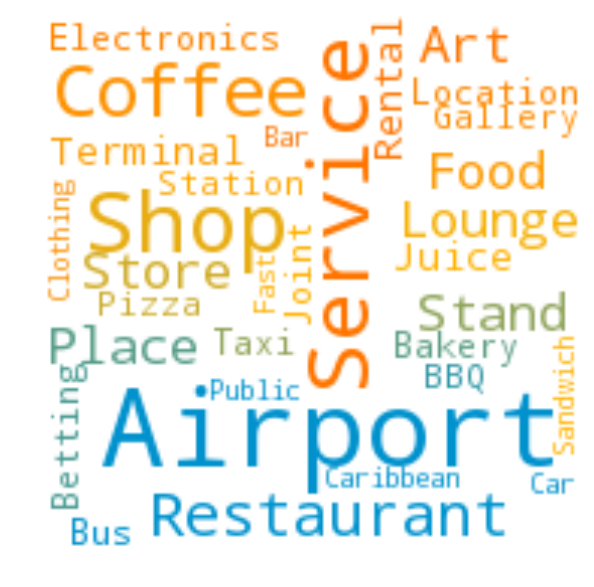

In [80]:
# Start with one station:
doc_sample = primary_text.iloc[0,1]
plot_word_cloud(doc_sample)

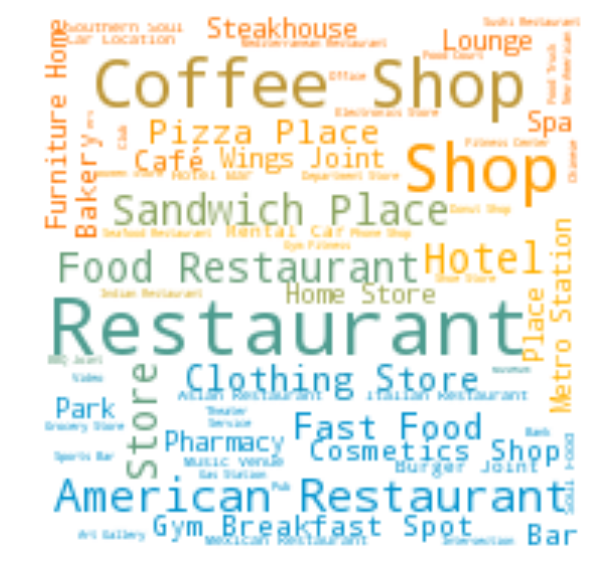

In [81]:
# All stations
tmp = primary_text['Venue Category']
tmp = tmp.T.squeeze()
doc_sample = tmp.str.cat(sep=', ')
plot_word_cloud(doc_sample)

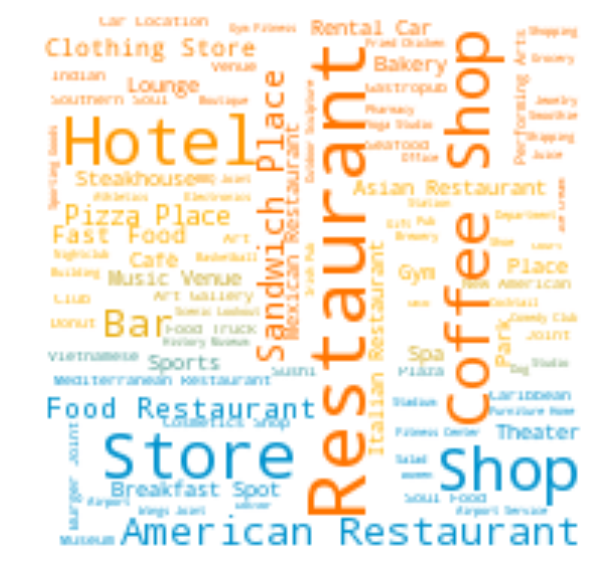

In [82]:
# Stations with no parking
tmp = primary_text['Venue Category']
tmp = tmp[stations['Parking'] == 0]
tmp = tmp.T.squeeze()
doc_sample = tmp.str.cat(sep=', ')
plot_word_cloud(doc_sample)

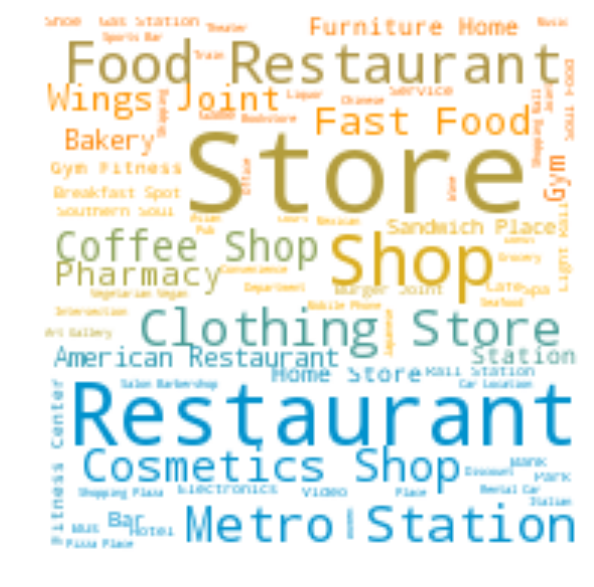

In [83]:
# Stations with parking
tmp = primary_text['Venue Category']
tmp = tmp[stations['Parking'] != 0]
tmp = tmp.T.squeeze()
doc_sample = tmp.str.cat(sep=', ')
plot_word_cloud(doc_sample)

# 3 MARTA Stations Clusters <a class="anchor" id="item300"></a>  

MARTA rail system is not very big. We really don't need any clustering for only 38 stations, 2/3 of which are park-and-ride stations with hardly any venues other than fast food restaurants around them. 

However, for educational purposes let's try to use TF-IDF frequencies to group MARTA stations into some category-related clusters. 

Let's drop station names

In [84]:
general_data = general_tfidf.drop('Station', 1)
general_data.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.226377,0.0,0.146263,0.000000,0.000000,0.000000,0.0,0.018036,0.609325
1,0.544379,0.0,0.094695,0.231238,0.050939,0.000000,0.0,0.011121,0.067628
2,0.170745,0.0,0.183865,0.235717,0.207701,0.000000,0.0,0.018138,0.183834
3,0.089988,0.0,0.029071,0.248460,0.328395,0.222185,0.0,0.033458,0.048443
4,0.000000,0.0,0.140028,0.000000,0.790904,0.000000,0.0,0.069068,0.000000


In [85]:
primary_data = primary_tfidf.drop('Station', 1)
primary_data.head()

,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Beer Store,Betting Shop,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Taxi,Taxi Stand,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Lounge,Tunnel,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.122003,0.244007,0.061002,0.000000,0.0,0.030954,0.000000,0.0,0.0,0.0,0.00000,0.030954,0.0,0.019330,0.0,0.000000,0.0,0.0,0.0,0.061002,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.030954,0.0,0.0,0.000000,0.0,0.0,0.030954,0.0,0.0,0.0,0.0,0.022388,0.000000,0.029837,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030954,0.0,0.0,0.000000,0.0,0.0,0.0,0.015588,0.0,0.0,0.0,0.0,0.061002,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.030954,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

Compute Euclidean distances between stations

In [86]:
from scipy.stats import wasserstein_distance
from scipy.spatial import distance

def plot_euclidean(data):
    num = data.shape[0]
    w = np.zeros((num,num))
    for i in range(num):
        for j in range(num):
            w[i,j] = distance.sqeuclidean(list(data.iloc[i]), list(data.iloc[j]))

    im = plt.imshow(w, cmap='hot', interpolation='nearest')
    plt.colorbar(im)
    plt.title('Euclidean')
    plt.savefig('MARTA_Euclidean'+str(data.shape[1])+'.png')
    plt.show()

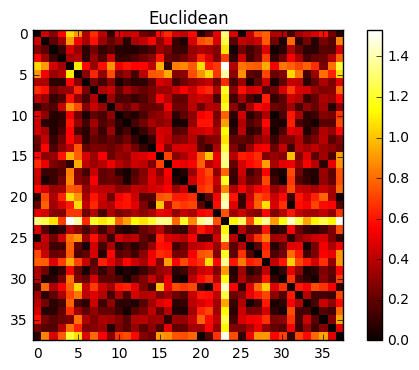

In [87]:
plot_euclidean(general_data)

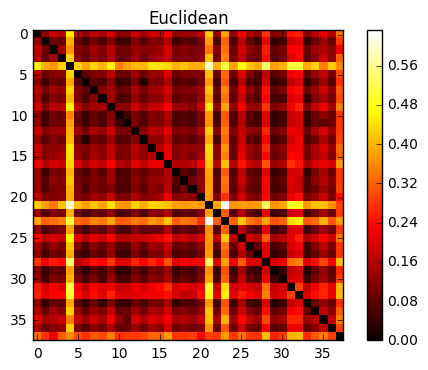

In [88]:
plot_euclidean(primary_data)

As we can see, all distances are very similar and close to 0, except for Bankhead, Indian Creek, Kensington, West Lake stations (indeces: [4, 21, 23, 37]). 

With a distance matrix like this K-means and other clustering algorithms are very likely to separate these 4 stations and consider the other 34 stations as one big cluster. 

In [89]:
bShowMetrices = False

Let's consider other distances. For example, let's compute pairwise Wasserstein distances between stations

In [90]:
def plot_wasserstein(data):
    num = data.shape[0]
    w = np.zeros((num,num))
    for i in range(num):
        for j in range(num):
            w[i,j] = wasserstein_distance(list(data.iloc[i]), list(data.iloc[j]))

    im = plt.imshow(w, cmap='hot', interpolation='nearest')
    plt.colorbar(im);
    plt.title('Wasserstein');
    plt.savefig('MARTA_Wasserstein'+str(data.shape[1])+'.png')
    plt.show()

In [91]:
if bShowMetrices:
    plot_wasserstein(general_data)

In [92]:
if bShowMetrices:
    plot_wasserstein(primary_data)

Let's compute the Hamming distance between stations, which is simply the proportion of disagreeing components in 2 vectors.

In [93]:
def plot_hamming(data):
    num = data.shape[0]
    w = np.zeros((num,num))
    for i in range(num):
        for j in range(num):
            w[i,j] = distance.hamming(list(data.iloc[i]), list(data.iloc[j]))

    im = plt.imshow(w, cmap='hot', interpolation='nearest')
    plt.colorbar(im);
    plt.title('Hamming');
    plt.savefig('MARTA_Hamming'+str(data.shape[1])+'.png')
    plt.show()

In [94]:
if bShowMetrices:
    plot_hamming(general_data)

In [95]:
if bShowMetrices:
    plot_hamming(primary_data)

## 3.1 K-Means <a class="anchor" id="item310"></a>  

Now we will analyze the K-Means with elbow method. Note that sklearn implementation of K-Means uses only Euclidean distances. 

In [96]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

def kmeans_elbow(data):
    distortions = []
    K = range(1,20)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig('MARTA_KMeans_Elbow'+str(data.shape[1])+'.png')
    plt.show()

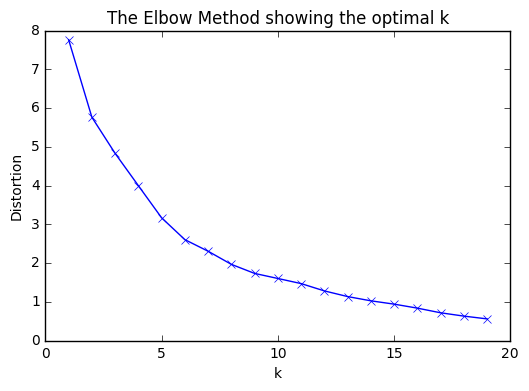

In [97]:
kmeans_elbow(general_data)

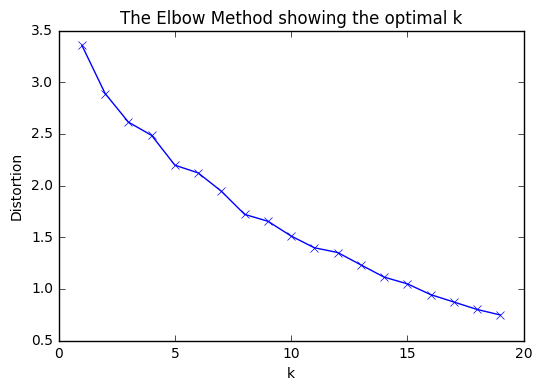

In [98]:
kmeans_elbow(primary_data)

There's no clear elbow in both plots. It suggests that there might be no meaningful clusters in our data. No elbow might also mean that the algorithm used cannot separate clusters (e.g. when K-means is used for concentric circles, vs DBSCAN). 

Nevertheless, let's run K-Means to cluster the stations and explore these clusters.

In [99]:
def kmeans(data, k):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)

    # check cluster labels generated for each row in the dataframe
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    print(cluster_labels)
    return cluster_labels

In [100]:
def print_clusters(grouped, cluster_labels, num_top_venues):
    kclusters = np.unique(cluster_labels).shape[0]
    for cluster in range(kclusters):
        print('-----Cluster ', cluster, '-----') 
        print(top_venues(grouped, num_top_venues, np.where(cluster_labels == cluster)[0].tolist(), True)) # bshorten_names=True

In [101]:
general_kmeans = kmeans(general_data, 9)
print_clusters(general_tfidf, general_kmeans, 2)

[1 0 3 3 2 3 3 8 7 6 3 0 3 3 1 6 2 0 0 4 1 1 7 5 3 1 3 7 8 3 0 1 6 3 0 2 6
 1]
-----Cluster  0 -----
          Station 1st Most Common Category 2nd Most Common Category
1     Arts Center     Arts & Entertainment           Nightlife Spot
11           Dome     Arts & Entertainment           Nightlife Spot
17    Five Points           Nightlife Spot     Arts & Entertainment
18        Garnett     Arts & Entertainment           Nightlife Spot
30   North Avenue     Arts & Entertainment           Nightlife Spot
34  Sandy Springs     Arts & Entertainment           Nightlife Spot
-----Cluster  1 -----
          Station 1st Most Common Category 2nd Most Common Category
0         Airport       Travel & Transport     Arts & Entertainment
14      East Lake       Travel & Transport    Outdoors & Recreation
20   H. E. Holmes       Travel & Transport                     Food
21   Indian Creek       Travel & Transport    Outdoors & Recreation
25       Lakewood       Travel & Transport     Arts & Enterta

Not bad, actually.

In [102]:
primary_kmeans = kmeans(primary_data, 9)
print_clusters(primary_tfidf, primary_kmeans, 2)

[6 5 5 5 4 5 5 5 5 5 5 0 5 5 5 5 0 5 5 5 5 3 5 2 5 5 5 5 7 5 5 5 8 5 5 0 5
 1]
-----Cluster  0 -----
      Station 1st Most Common Category 2nd Most Common Category
11       Dome       Basketball Stadium        Outdoor Sculpture
16   Edgewood              Flower Shop                 Platform
35  Vine City              Sports Club            Souvenir Shop
-----Cluster  1 -----
      Station 1st Most Common Category 2nd Most Common Category
37  West Lake              Gas Station       Light Rail Station
-----Cluster  2 -----
       Station 1st Most Common Category 2nd Most Common Category
23  Kensington             Chiropractor           Discount Store
-----Cluster  3 -----
         Station 1st Most Common Category 2nd Most Common Category
21  Indian Creek       Light Rail Station              Bus Station
-----Cluster  4 -----
    Station 1st Most Common Category 2nd Most Common Category
4  Bankhead           Ice Cream Shop              Gas Station
-----Cluster  5 -----
             Stat

We can also use Entries/Day, number of venues, Parking and other data for clustering, together with TF-IDF frequencies. We will just need to normalize data matrix before feeding it to Kmeans. 

C:\Users\nely_\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\nely_\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


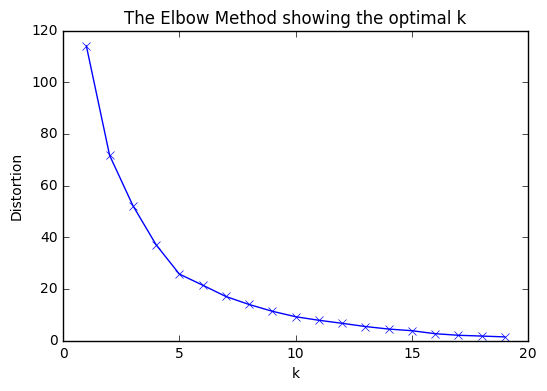

In [103]:
from sklearn.preprocessing import StandardScaler

clustering_data = StandardScaler().fit_transform(merged[["Parking","Venue","Entries/Day"]])
kmeans_elbow(clustering_data)

In [104]:
parking_clusters = kmeans(clustering_data, 5)

[4 4 2 2 2 0 1 2 4 0 4 4 0 0 2 2 2 3 4 4 2 2 2 0 4 2 0 0 2 1 4 0 2 1 0 4 2
 2]


Let's play with some other clustering algorithms.

In [105]:
bPrintClusters = False

## 3.2 DBSCAN <a class="anchor" id="item320"></a>    

In [106]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)

sorted(sklearn.neighbors.VALID_METRICS['brute'])

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'wminkowski',
 'yule']

In [107]:
def dbsc(data):
    # Compute DBSCAN hamming
    dbscan_dataSet = StandardScaler().fit_transform(data)
    db = DBSCAN(eps=0.15, min_samples=1, metric='hamming').fit(dbscan_dataSet)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    cluster_labels = db.labels_
    print(cluster_labels)
    return cluster_labels

In [108]:
general_dbsc = dbsc(general_data)
if bPrintClusters:
    print_clusters(general_tfidf, general_dbsc, 2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


In [109]:
primary_dbsc = dbsc(primary_data)
if bPrintClusters:
    print_clusters(primary_tfidf, primary_dbsc, 2)

[ 0  1  0  0  0  0  2  0  0  0  3  4  0  5  0  0  0  0  0  0  0  0  6  0
  7  0  0  8  0  9 10  0  0 11  0  0  0  0]


## 3.3. Hierarchical clustering <a class="anchor" id="item330"></a>    

Unfortunately we can not pass custom distance metrics (e.g. Wasserstein distance) to Sklearn.KMeans. But we can do it with fclusterdata. This function performs hierarchical clustering using the single linkage algorithm, and forms flat clusters using the inconsistency method with t=1.0 as the cut-off threshold.

In [110]:
import numpy as np
from scipy.cluster.hierarchy import fclusterdata

def fclust(data):
    #fclust = fclusterdata(primary_data, 1.0, metric='euclidean')
    fclust = fclusterdata(data, 1.0, metric=wasserstein_distance)
    cluster_labels = fclust - 1
    print(cluster_labels)
    #print(np.allclose(fclust1, fclust2))
    return cluster_labels

In [111]:
general_fclust = fclust(general_data)
if bPrintClusters:
    print_clusters(general_tfidf, general_fclust, 2)

[6 6 5 3 6 6 5 1 4 1 4 4 3 4 1 0 6 3 6 2 6 0 7 8 3 6 3 6 0 4 6 0 6 2 3 1 3
 6]


In [112]:
primary_fclust = fclust(primary_data)
if bPrintClusters:
    print_clusters(primary_tfidf, primary_fclust, 2)

[4 2 2 2 5 2 2 2 2 2 2 2 2 3 2 2 0 2 2 2 2 5 2 5 2 0 2 2 1 2 2 1 1 2 2 0 2
 5]


## 3.4 Agglomerative Hierarchical Clustering <a class="anchor" id="item340"></a>    

In [113]:
from sklearn.cluster import AgglomerativeClustering
def aggl(data):
    aggl = AgglomerativeClustering(n_clusters=10, affinity='hamming', linkage='complete')
    cluster_labels = aggl.fit_predict(data) 
    print(cluster_labels) 
    return cluster_labels

In [114]:
general_aggl = dbsc(general_data)
if bPrintClusters:
    print_clusters(general_tfidf, general_aggl, 2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


In [115]:
primary_aggl = dbsc(primary_data)
if bPrintClusters:
    print_clusters(primary_tfidf, primary_aggl, 2)

[ 0  1  0  0  0  0  2  0  0  0  3  4  0  5  0  0  0  0  0  0  0  0  6  0
  7  0  0  8  0  9 10  0  0 11  0  0  0  0]



# 4. MARTA Stations Annotated Maps <a class="anchor" id="item400"></a>   

Let's visualize our results using Folium maps.

We can create many different maps, for example:

- general categories clusters and general categories labels
- primary categories clusters and primary categories labels
- general categories clusters and primary categories labels
- parking data (parking/no parking) and general categories labels, etc.

In [116]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="atlanta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Atlanta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Atlanta are 33.7490987, -84.3901849.


In [117]:
from scipy.stats import mode
def show_map_clusters(top, stations, venues, cluster_labels, bvenues, map_name):
    
    # Merge all station data into one dataframe
    merged = stations
    # add latitude/longitude for each neighborhood
    merged = merged.join(top.set_index('Station'), on='Station')
    # add venues
    merged = merged.join(venues, on='Station')
    # add clustering labels
    #if 'Cluster Labels' in merged.columns:
    merged['Cluster Labels'] = cluster_labels
    #else:
    #    merged.insert(2, 'Cluster Labels', cluster_labels)
   
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    # MARTA Orange: #ea7d09 rgb(234, 125, 9)
    # MARTA Blue: #3e78da rgb(62, 120, 218)   
    kclusters = np.unique(cluster_labels).shape[0]
    counts = np.bincount(cluster_labels)
    common_cluster = np.argmax(counts)
    bcommon_cluster = np.max(counts) >= len(cluster_labels)/2
    
    xs = np.arange(kclusters)
    ys = [i + xs + (i*xs)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, top1, top2, cluster, num, cnt in zip(merged['Latitude'], merged['Longitude'], merged['Station'], 
                merged['1st Most Common Category'], merged['2nd Most Common Category'], merged['Cluster Labels'], 
                merged['Entries/Day'], merged['Venue']):    
        
        if bvenues:
            rad = cnt / 5
        else:
            rad = num / 500
        label = folium.Popup(split_it(poi) + ': ' + top1 + ', ' + top2, parse_html=True)
        tooltip = label
        if bcommon_cluster:
            if cluster != common_cluster: 
                color = 'blue' #  '#3e78da' 
                fill_color = '#3186cc' 
            else:
                color = "red" 
                fill_color = '#f4a8a7'
        else:
            color = rainbow[cluster-1]
            fill_color = rainbow[cluster-1]

        folium.CircleMarker(
            [lat, lon],
            radius=rad,
            popup=label,
            tooltip=tooltip,
            color=color,
            fill=True,
            fill_color=fill_color,
            fill_opacity=0.7).add_to(map_clusters)
    
    map_clusters.save('MARTA_map_'+map_name+str(int(bvenues))+'.html')
    return map_clusters, merged

In [118]:
print("Number of stations with <  26 venues: ", venues_count[venues_count['Venue'] < 26].count())
print("Number of stations with >= 26 venues: ", venues_count[venues_count['Venue'] >= 26].count())

Number of stations with <  26 venues:  Venue    22
dtype: int64
Number of stations with >= 26 venues:  Venue    16
dtype: int64


In [119]:
general_map, general_merged_tfidf = show_map_clusters(general_top_tfidf, stations, venues_count, general_kmeans, True, "general_kmeans")
general_map

In [120]:
primary_map, primary_merged_tfidf = show_map_clusters(primary_top_tfidf, stations, venues_count, primary_kmeans, True, "primary_kmeans")
primary_map

In [121]:
hybrid_map, hybrid_merged_tfidf = show_map_clusters(primary_top_tfidf, stations, venues_count, general_kmeans, True, "hybrid_kmeans")
hybrid_map

In [122]:
parking_map, parking_merged_tfidf = show_map_clusters(general_top_tfidf, stations, venues_count, 
                                                      list(stations['Parking'].map({0: 0, 1: 1, 2: 1})), True, "general_parking")
parking_map

In [123]:
parking_map, parking_merged_tfidf = show_map_clusters(primary_top_tfidf, stations, venues_count, 
                                                      list(stations['Parking'].map({0: 0, 1: 1, 2: 1})), True, "primary_parking")
parking_map

In [124]:
parking_map, parking_merged_tfidf = show_map_clusters(general_top_tfidf, stations, venues_count, 
                                                      parking_clusters, True, "clustering_parking")
parking_map

We can click on each station and see its label\annotation. 

# Results <a class="anchor" id="item500"></a>

-	I used Foursquare to retrieve 223 primary and 9 general categories for 1156 popular venues near 38 MARTA stations
-	I analyzed Entries/Day and number of venues for each MARTA station
-	I discovered that number of nearby venues is strongly correlated with free parking
-	I discovered that MARTA stations can be roughly divided into two major groups: park-and-ride stations, with < 26 venues, and urban stations with no parking and ≥ 26 venues. Three important exceptions are Dunwoody, Lindbergh Center and Inman Park/Reynoldstown located in dense areas. These stations have free parking and many venues nearby
-	I discovered that fast food restaurants, coffee shops and retail shops prevail in areas around all MARTA stations
-	I used TF-IDF and LDA algorithms to extracted venue categories that are most specific\discriminative for each station and used these categories to label\annotate each station
-	I used K-means and other clustering algorithms to group MARTA stations into ~10 clusters based on their venues categories
-	I visualized MARTA data on interactive Folium maps


# Discussion <a class="anchor" id="item600"></a>   

Results for Buckhead, Midtown and Peachtree Center are incomplete, since these stations reached Foursquare API’s venue result limit of 100. We can get more Foursquare results by using nearby points. The results may overlap, so we will need to filter the duplicates out and keep changing the point by a tiny margin till the number of unique venues for each station stops growing or reaches some limit.

MARTA venue analysis can be enriched also by using secondary categories, foot traffic and other detailed information for each venue. This require Foursquare primary calls, so I left it beyond the scope of this small project.

Category merging using Foursquare category tree also has much room for improvement. For example, parent category for "Pharmacy" is "Shop & Service". This makes Medical Center look like any other station.

MARTA station labeling is basically a text document labeling/annotation and topic modeling problem. There are many algorithms for this, with many tunable parameters. It would be interesting, for example, to vary number of topics and build LDA models with different detalization. 

                                               
# Conclusion <a class="anchor" id="item700"></a>  

I analyzed popular venues near 38 MARTA rail stations in Atlanta, Georgia.  

My analysis revealed very low business activity (less than 26 venues) around 18 out of 22 MARTA stations with free parking. Three important exceptions are Dunwoody (I-285/SR 400 interchange), Lindbergh Center (I-85/SR 400 interchange) and Inman Park/Reynoldstown. These three stations provide free daily parking for MARTA passengers, and are located in heavily dense areas with many businesses.

I also discovered that only Civic Center, Lindbergh Center, Inman Park/Reynoldstown, and potentially Buckhead, Midtown and Peachtree Center have Residence venues within walking distance from the train station. Georgia State is the only MARTA station with venues in College & University category.

Fast food restaurants and coffee shops dominate areas around all MARTA stations. Obviously, this is where people spend most of 
their time and money, which is a good news for the fast food companies. 

I used TF-IDF and LDA techniques to label each MARTA station with its discriminative categories/topics. It turned out that there are many Nightlife Spots near MARTA, combined either with Arts & Entertainment, or Food venues.

I created interactive Folium maps of Atlanta with information for each MARTA stations (name, venue categories-based label,  Entries/Day, number of venues, free parking) superimposed on top.

I also discovered that there is a good chiropractic at Kensington station in Atlanta.

### Thank you for reading!

This notebook was created by Nelli Fedorova(https://www.linkedin.com/in/nelli-fedorova-7710b01a/). I hope you found this report interesting and educational. 

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).